In [1]:
#################### Partie I ####################

#-------------------------------#
# Chargement des modules Python #
#-------------------------------#

import math as mt
import random as rm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from mpl_toolkits.mplot3d import Axes3D 
from copy import copy, deepcopy

#-------------------#
# Valeurs initiales #
#-------------------#

t=0
K=10
T=1
r=0.1
sigma=0.5
S0=0.2

#-----------------#
# Données tableau #
#-----------------#

K_liste=[5125,5225,5325,5425,5525,5625,5725,5825]
M_liste=[475,405,340,280.5,226,179.5,139,105]

#------------------------------------#
# Fonction de répartition loi N(0,1) # 
#------------------------------------#

def repartition(x):
    return (1/2)*(1+mt.erf(x/mt.sqrt(2)))

#-------------------#
# Fonction d1 et d2 # 
#-------------------#

def d1(t, S, K, T, r, sigma):
    return (mt.log(S/K)+(r+(1/2)*mt.pow(sigma,2))*(T-t))/(sigma*mt.sqrt(T-t))

def d2(t, S, K, T, r, sigma):
    return (mt.log(S/K)+(r-(1/2)*mt.pow(sigma,2))*(T-t))/(sigma*mt.sqrt(T-t))

#-------------------------------#
# Fonction Call Black & Scholes # 
#-------------------------------#

def Call_BS(t, S, K, T, r, sigma):
    if t==T:
        return max(S-K, 0)
    else:
        return S*repartition(d1(t, S, K, T, r, sigma)) - K*mt.exp(-r*(T-t))*repartition(d2(t, S, K, T, r, sigma))
    
#-------------------------------#
# Fonction Vega Black & Scholes # 
#-------------------------------#

def Vega_BS(t, S, K, T, r, sigma):
    return ((S*mt.sqrt(T-t))/mt.sqrt(2*np.pi))*mt.exp(-(mt.pow(d1(t, S, K, T, r, sigma),2)/2))
                                                    

In [2]:
#-------------------------------#
#            Tests              # 
#-------------------------------#

S0_liste = []
Call_Test = []
Vega_Test = []
                                                      
for i in range(1, 101):
    S0_liste.append(S0*i)
    Call_Test.append(Call_BS(t, S0_liste[i-1], K, T, r, sigma))
    Vega_Test.append(Vega_BS(t, S0_liste[i-1], K, T, r, sigma))   

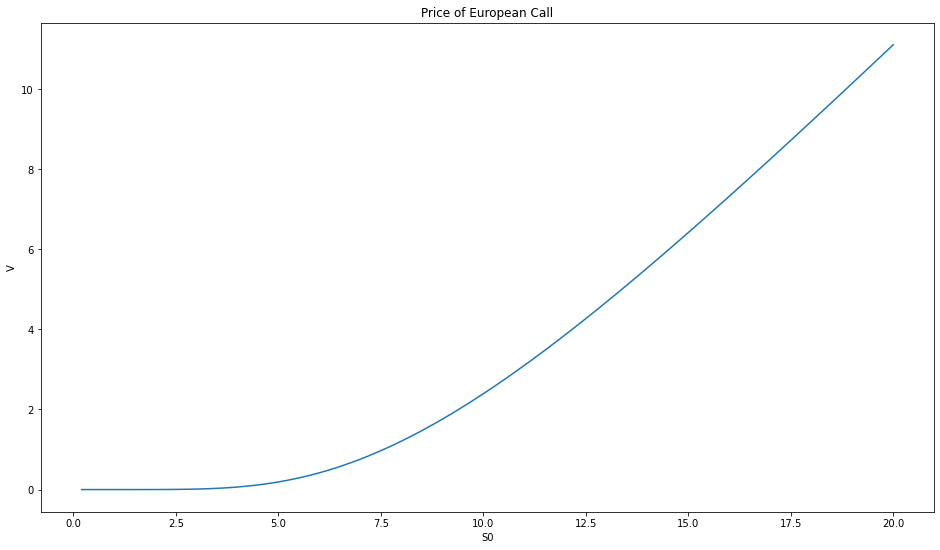

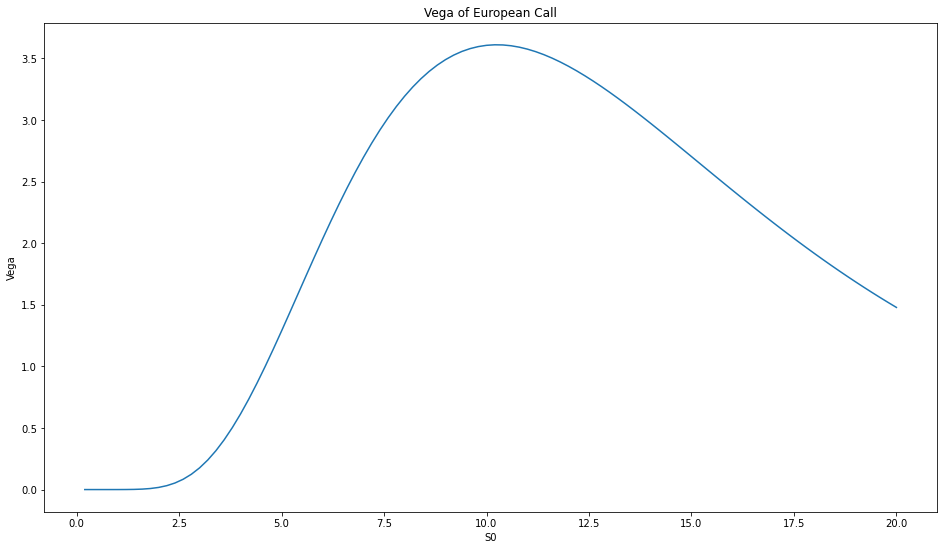

In [3]:
#-------------------------------#
#            Figures            # 
#-------------------------------#

plt.rcParams["figure.figsize"]=[16,9]
plt.plot(S0_liste, Call_Test)
plt.xlabel("S0")
plt.ylabel("V")
plt.title("Price of European Call")
plt.show()

plt.plot(S0_liste, Vega_Test)
plt.xlabel("S0")
plt.ylabel("Vega")
plt.title("Vega of European Call")
plt.show()

In [4]:
#-------------------#
# Valeurs initiales #
#-------------------#

t=0
r=0.05
epsilon=mt.pow(10,-3)
T=4/12
S0= 5430.3
volatilite_implicite_2D=[]
sigma_liste=[]

#-------------------#
#     Données       #
#-------------------#

M_liste=[475,405,340,280.5,226,179.5,139,105]
T_liste = np.linspace(0.05, 3, 8)
K_liste=[5125,5225,5325,5425,5525,5625,5725,5825]

#-------------------#
#     Fonction F    #
#-------------------#

def F(V_M, t, S, K, T, r, sigma):
    return Call_BS(t, S, K, T, r, sigma) - V_M

#--------------------------------#
#     Volatilité implicite 2D    #
#--------------------------------#

#n=1

for i in range(len(M_liste)):
    if ((M_liste[i] < S0) and (M_liste[i] >= max(S0-K_liste[i]*mt.exp(-r*T), 0))):
        sigma_liste.append(mt.sqrt(2*abs(mt.log(S0/K_liste[i]) + r*T)/T))

        while abs(F(M_liste[i], t, S0, K_liste[i], T, r, sigma_liste[-1])) > epsilon:
            sigma_liste.append(sigma_liste[-1] - F(M_liste[i], t, S0, K_liste[i], T, r, sigma_liste[-1])/Vega_BS(t, S0, K_liste[i], T, r, sigma_liste[-1]))

        volatilite_implicite_2D.append(sigma_liste[-1])
    else:
        volatilite_implicite_2D.append(0)


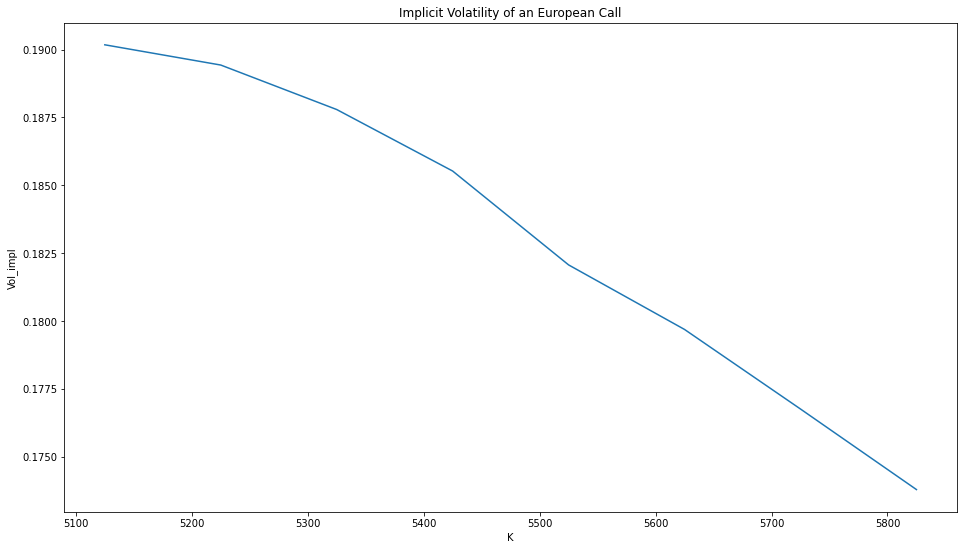

In [5]:
#-------------------------------#
#            Figure             # 
#-------------------------------#

plt.rcParams["figure.figsize"]=[16,9]
plt.plot(K_liste, volatilite_implicite_2D)
plt.xlabel("K")
plt.ylabel("Vol_impl")
plt.title("Implicit Volatility of an European Call")
plt.show()    


In [6]:
#################### Partie II ####################


#-------------------------------#
#       Importer la data        # 
#-------------------------------#

data = pd.read_csv("Calibration_TP1_data.csv", sep =',')

#-------------------#
# Valeurs initiales #
#-------------------#

r = 0.046
q = 0.02
S0 = 1260.36

V_Call_Market = []
V_Put_Market = []
S0_discounted = []


for i in range(len(data[' T'])):
    V_Call_Market.append((data['Cb'][i] + data['Ca'][i])/2)
    V_Put_Market.append((data['Pb'][i] + data['Pa'][i])/2)
    S0_discounted.append(S0*mt.exp(-q*data[' T'][i]))

data['V_Call_Market'] = V_Call_Market
data['V_Put_Market'] = V_Put_Market
data['S0_discounted'] = S0_discounted

T_liste_data = data[' T'].unique()

#-------------------#
#   Corps du code   #
#-------------------#

Matrix_vol_impl = []
K_Matrix = []
for j in range(len(T_liste_data)):
    volatilite_implicite=[]
    K_sub_list = []
    for i in range(len(data['V_Call_Market'])):
        if data[' T'][i] == T_liste_data[j]:
            if ((data['V_Call_Market'][i] < data['S0_discounted'][i]) and (data['V_Call_Market'][i] >= max(data['S0_discounted'][i]-data['K'][i]*mt.exp(-(data['r'][i]/100)*T_liste_data[j]), 0))):
                sigma_liste=[]
                sigma_liste.append(mt.sqrt(2*abs(mt.log(data['S0_discounted'][i]/data['K'][i]) + (data['r'][i]/100)*T_liste_data[j])/T_liste_data[j]))

                while abs(F(data['V_Call_Market'][i], t, data['S0_discounted'][i], data['K'][i], T_liste_data[j], (data['r'][i]/100), sigma_liste[-1])) > epsilon:
                    sigma_liste.append(sigma_liste[-1] - F(data['V_Call_Market'][i], t, data['S0_discounted'][i], data['K'][i], T_liste_data[j], (data['r'][i]/100), sigma_liste[-1])/Vega_BS(t, data['S0_discounted'][i], data['K'][i], T_liste_data[j], (data['r'][i]/100), sigma_liste[-1]))

                volatilite_implicite.append(sigma_liste[-1])
            else:
                volatilite_implicite.append(0)
            K_sub_list.append(data['K'][i])
    
    Matrix_vol_impl.append(volatilite_implicite)
    K_Matrix.append(K_sub_list)

Matrix_vol_impl_non_Null = []
K_Matrix_non_Null = []

for i in range(len(Matrix_vol_impl)):
    Sigma_non_null = []
    K_non_Null = []
    for j in range(len(Matrix_vol_impl[i])):
        if Matrix_vol_impl[i][j] != 0 :
            Sigma_non_null.append(Matrix_vol_impl[i][j])
            K_non_Null.append(K_Matrix[i][j])
            
    Matrix_vol_impl_non_Null.append(Sigma_non_null)
    K_Matrix_non_Null.append(K_non_Null)

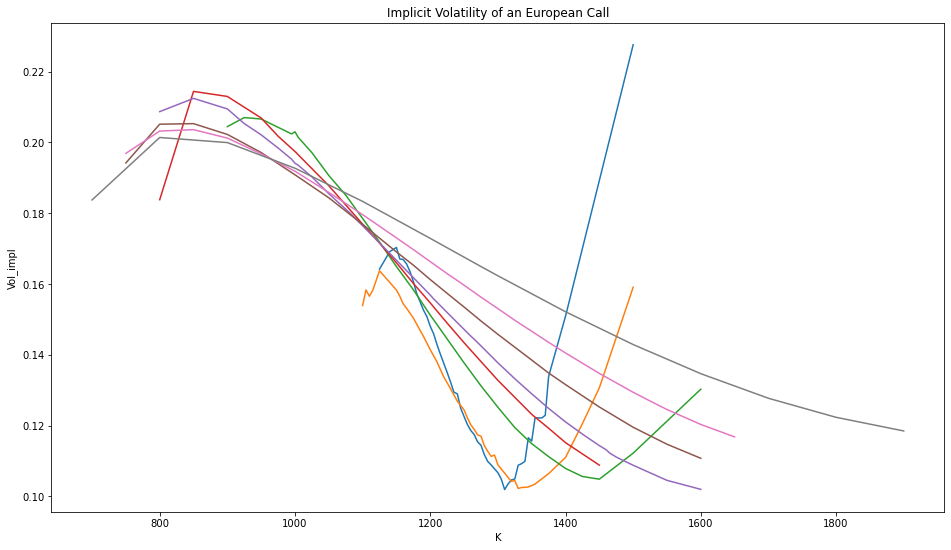

In [7]:
#-----------------------------------------------------------------#
# L'ensemble des courbes de (K, sigma_implicite) sur un même plan #
#-----------------------------------------------------------------#

plt.rcParams["figure.figsize"]=[16,9]
for i in range(len(T_liste_data)):
    plt.plot(K_Matrix_non_Null[i], Matrix_vol_impl_non_Null[i])
plt.xlabel("K")
plt.ylabel("Vol_impl")
plt.title("Implicit Volatility of an European Call")
plt.show()

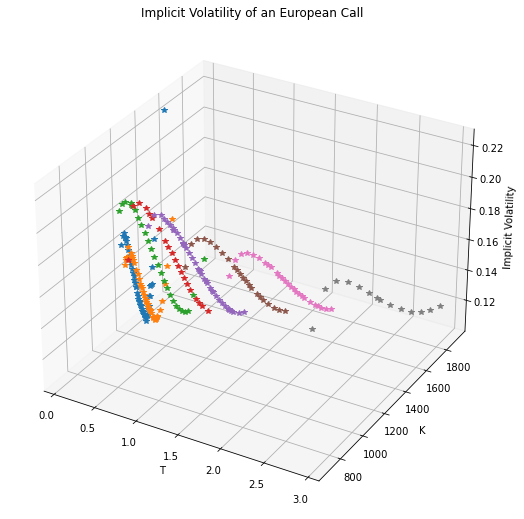

In [8]:

x=[1 for k in range((len(K_Matrix_non_Null[0])))]
y=K_Matrix_non_Null[0]

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for j in range(len(K_Matrix_non_Null)):
    x=[T_liste_data[j] for p in range(len(K_Matrix_non_Null[j]))]
    y=K_Matrix_non_Null[j]

    ax.plot(x,y,Matrix_vol_impl_non_Null[j],"*")
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('Implicit Volatility')
plt.title("Implicit Volatility of an European Call")
plt.show()

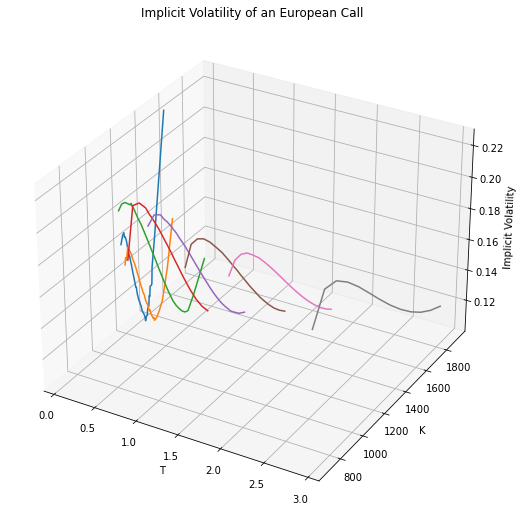

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for j in range(len(K_Matrix_non_Null)):
    x=[T_liste_data[j] for p in range(len(K_Matrix_non_Null[j]))]
    y=K_Matrix_non_Null[j]

    ax.plot(x,y,Matrix_vol_impl_non_Null[j])
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('Implicit Volatility')
plt.title("Implicit Volatility of an European Call")
plt.show()

In [12]:
#-----------------------------------------------#
#       Avec la relation Call-Put parité        #
# en exprimmant V_Put_M en fonction de V_Call_M #
#-----------------------------------------------#

#-----------------------------------#
# Fonction Vega Put Black & Scholes #
# Sanchant que Vega_Put = Vega_Call #
#-----------------------------------#

def Put_BS(t, S, K, T, r, sigma):
    return Call_BS(t, S, K, T, r, sigma)-S+K*mt.exp(-r*(T-t)) 
    
#-------------------------------------------# 
#   Fonction F2 (V_M c'est prix du marché)  #
#-------------------------------------------#  

def F2(V_M, t, S, K, T, r, sigma):
    return Put_BS(t, S, K, T, r, sigma) - V_M 

#------------------#  
#   Corps du code  #
#------------------#  

Matrix_vol_impl_Put1 = []
K_Matrix_Put1 = []

for j in range(len(T_liste_data)):
    volatilite_implicite=[]
    K_sub_list = []
    for i in range(len(data['V_Call_Market'])):
        if data[' T'][i] == T_liste_data[j]:
            if ((data['V_Put_Market'][i] < data['K'][i]*mt.exp(-(data['r'][i]/100)*T_liste_data[j])) and (data['V_Put_Market'][i] >= max(data['S0_discounted'][i]-data['K'][i]*mt.exp(-(data['r'][i]/100)*T_liste_data[j]), 0) - data['S0_discounted'][i] + data['K'][i]*mt.exp(-(data['r'][i]/100)*T_liste_data[j]))):
                sigma_liste=[]
                sigma_liste.append(mt.sqrt(2*abs(mt.log(data['S0_discounted'][i]/data['K'][i]) + (data['r'][i]/100)*T_liste_data[j])/T_liste_data[j]))

                n=1
                while abs(F2(data['V_Put_Market'][i], t, data['S0_discounted'][i], data['K'][i], T_liste_data[j], (data['r'][i]/100), sigma_liste[-1])) > epsilon:
                    sigma_liste.append(sigma_liste[-1] - F2(data['V_Put_Market'][i], t, data['S0_discounted'][i], data['K'][i], T_liste_data[j], (data['r'][i]/100), sigma_liste[-1])/Vega_BS(t, data['S0_discounted'][i], data['K'][i], T_liste_data[j], (data['r'][i]/100), sigma_liste[-1]))
                    n=n+1

                volatilite_implicite.append(sigma_liste[-1])
            else:
                volatilite_implicite.append(0)
            K_sub_list.append(data['K'][i])
    
    Matrix_vol_impl_Put1.append(volatilite_implicite)
    K_Matrix_Put1.append(K_sub_list)

Matrix_vol_impl_non_Null_Put1 = []
K_Matrix_non_Null_Put1 = []

for i in range(len(Matrix_vol_impl_Put1)):
    Sigma_non_null = []
    K_non_Null = []
    for j in range(len(Matrix_vol_impl_Put1[i])):
        if Matrix_vol_impl_Put1[i][j] != 0 :
            Sigma_non_null.append(Matrix_vol_impl_Put1[i][j])
            K_non_Null.append(K_Matrix_Put1[i][j])
            
    Matrix_vol_impl_non_Null_Put1.append(Sigma_non_null)
    K_Matrix_non_Null_Put1.append(K_non_Null)

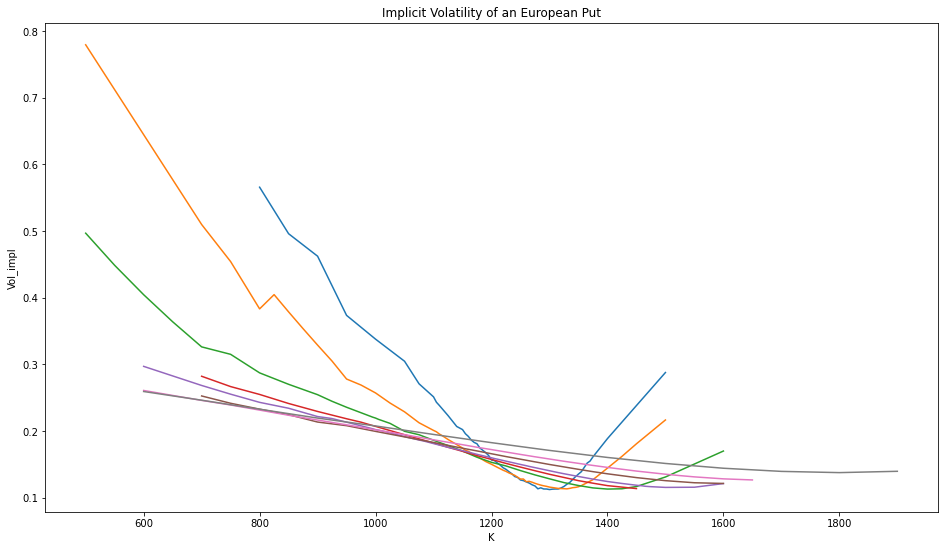

In [13]:
#-----------------------------------------------------------------#
# L'ensemble des courbes de (K, sigma_implicite) sur un même plan #
#-----------------------------------------------------------------#

plt.rcParams["figure.figsize"]=[16,9]
for i in range(len(T_liste_data)):
    plt.plot(K_Matrix_non_Null_Put1[i], Matrix_vol_impl_non_Null_Put1[i])
plt.xlabel("K")
plt.ylabel("Vol_impl")
plt.title("Implicit Volatility of an European Put")
plt.show()

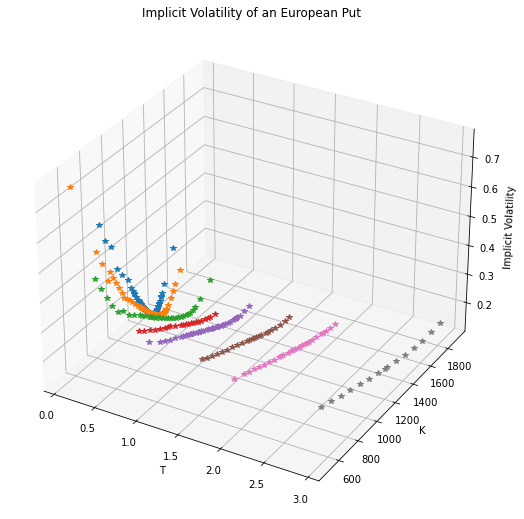

In [14]:
x=[1 for k in range((len(K_Matrix_non_Null_Put1[0])))]
y=K_Matrix_non_Null_Put1[0]


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for j in range(len(K_Matrix_non_Null_Put1)):
    x=[T_liste_data[j] for p in range(len(K_Matrix_non_Null_Put1[j]))]
    y=K_Matrix_non_Null_Put1[j]

    ax.plot(x,y,Matrix_vol_impl_non_Null_Put1[j],"*")
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('Implicit Volatility')
plt.title("Implicit Volatility of an European Put")
plt.show()

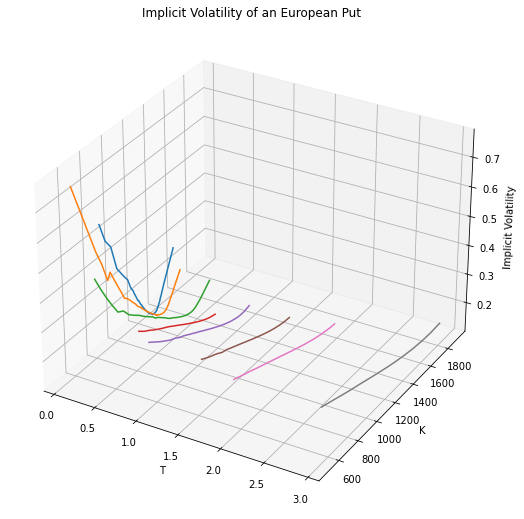

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for j in range(len(K_Matrix_non_Null_Put1)):
    x=[T_liste_data[j] for p in range(len(K_Matrix_non_Null_Put1[j]))]
    y=K_Matrix_non_Null_Put1[j]

    ax.plot(x,y,Matrix_vol_impl_non_Null_Put1[j])
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('Implicit Volatility')
plt.title("Implicit Volatility of an European Put")
plt.show()